In [500]:
import os
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import get_execution_role
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
my_region = sagemaker_session.boto_session.region_name
import statsmodels.formula.api as smf

In [501]:
my_region

'ap-south-1'

In [502]:
# Read dataset through S3 bucket
training_data_uri = 'CV_final_df.csv'.format(my_region)

In [503]:
training_data_uri

'CV_final_df.csv'

In [504]:
#!pip install pandas-profiling
#!pip install scipy

In [505]:
import pandas as pd
import numpy as np
#import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '%0.3f' % x)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import warnings
warnings.filterwarnings('ignore')

In [506]:
df = pd.read_csv('CV_final_df.csv')

In [507]:
df

,UNIQUESERIALNO,SOLD_DATE,MAKE YEAR,Make,Model,Variant,BodyType,WHEELS,GVW_HP_SEATING_CAPACITY_CC,FUEL TYPE_CLEANED,SOLD AMOUNT,STATE_MAPPED,BUSINESS_UNIT,LOT_AUC_CODE,AUCTION PLACE,VEH INWARD UNIT,YARD NAME,YARD UNIT,LOT NO,BIDDER ID,CUST CODE,NAME,VEHICLE NO,METER READING,SPECIFICATION,ADD NOTE,UCR,SHROT COND_MAPPED,INS DT,TAX,PERMIT_MAPPED,SHOOT PRICE,RESERVE PRICE,SELLER CORPORATE NAME,SELLER ID,SELLER NAME,KEY REF NUMBER,INV_H_CATEGORY_mapping,INV_H_RC_STATUS_CLEANED_MAPPED,SALETYPE,SAL_PROVISIONAL_DT,GP_PURPOSE_CLEANED,GP_DATETIME,GP_CREATED_ON,OUTWARD_DATE,SALE_CLOSURE_DATE,INW_ENTRY_DATE,INW_CREATED_DATE,VEHICLECONDITION
0,S15081800547,19-08-2015,2008,TATA,MAGIC,4X2MINIBUS,MINI BUS,0.000,0.000,DIESEL,87000,Andhra Pradesh,Kurnool,KAM20150819033,SHRIRAMAUTOMALLKURNOOL,KURYD,Shriram Automall Kurnool,KURYD,24,106,AC000002408,KOTESWARA RAO CH,AP21TV0421,NaN,NaN,NaN,NaN,FAIR,Live : 27/01/2016,Life Time,NOT AVAILABLE,NaN,NaN,NaN,AT0000000668,RAMANJANEYULU T,NONSTFC0421,CV,ORIGINAL RC,NaN,NaN,DELIVERY FOR BUYER,21-08-2015 11:03,21-08-2015 11:06,21-08-2015 21:21,NaN,19-08-2015 00:00,19-08-2015 22:13,MOVABLE
1,S15081800429,19-08-2015,2008,TATA,ACE,4X2PICKUP,SCV,4.000,1300.000,DIESEL,125000,Andhra Pradesh,Kurnool,KAM20150819033,SHRIRAMAUTOMALLKURNOOL,KURYD,Shriram Automall Kurnool,KURYD,44,149,AS00000089710,NOORAHAMMED SHAIK,AP21Y6559,NaN,NaN,NaN,NaN,INVALID DETAILS,Not Available,Paid upto : 30/09/2015,NOT AVAILABLE,133333.000,120000.000,NaN,AE0000000530,SRIDHAR GOUD E,AP21Y6559,CV,ORIGINAL RC,NaN,NaN,DELIVERY FOR BUYER,27-08-2015 14:20,27-08-2015 17:44,28-08-2015 10:47,NaN,19-08-2015 00:00,19-08-2015 21:53,IMMOVABLE
2,S15081400604,08-09-2015,2009,TATA,ACE,4X2PICKUP,SCV,4.000,1300.000,DIESEL,76000,Andhra Pradesh,Kurnool,KAM20150908049,SHRIRAMAUTOMALLKURNOOL,KURYD,Shriram Automall Kurnool,KURYD,110,179,AK00000001112,RANGASWAMY K,AP03X6737,112721.000,"Spring susp,",NaN,NaN,FAIR,Live : 01/11/2018,Expired : 30/09/2017,NOT AVAILABLE,NaN,NaN,a9,AB000031351,PEDDA NAGANNA B,KURNOO311270003,CV,NOT AVAILABLE,NaN,NaN,DELIVERY FOR BUYER,10-09-2015 17:20,10-09-2015 18:17,11-09-2015 11:34,NaN,13-08-2015 00:00,14-08-2015 18:13,MOVABLE
3,S15081300508,08-09-2015,2008,MAHINDRA,MAXX,4X2PICKUP,PICKUP,4.000,2930.000,DIESEL,115000,Andhra Pradesh,Kurnool,KAM20150908049,SHRIRAMAUTOMALLKURNOOL,KURYD,Shriram Automall Kurnool,KURYD,119,143,AS00000027710,RABBANI SK,AP21W9773,NaN,"Spring susp,","Form 36,28,29,30 Will be given within 30 days ...",NaN,INVALID DETAILS,Live : 23/12/2015,Paid upto : 30/06/2015,NOT AVAILABLE,150000.000,135000.000,a9,AN000024401,NANDULA NAIK N,KURNOO210260003,CV,NOT AVAILABLE,NaN,NaN,DELIVERY FOR BUYER,05-10-2015 16:20,05-10-2015 16:49,06-10-2015 12:17,NaN,13-08-2015 00:00,13-08-2015 18:07,IMMOVABLE
4,S15080300309,17-10-2015,2010,TATA,ACEHT,4X2PICKUP,SCV,4.000,1300.000,DIESEL,88000,Andhra Pradesh,Kurnool,KAM20151017033,SHRIRAMAUTOMALLKURNOOL,KURYD,Shriram Automall Kurnool,KURYD,24,117,AG00000086112,VENKATESWARREDDY GUMMATAM,AP04Y4218,NaN,spring suspention,NaN,NaN,FAIR,Not Available,Paid upto : 31/12/2015,NOT AVAILABLE,150000.000,135000.000,a9,AK000063901,KRISHNAIAH K,KURNOO401170009,CV,ORIGINAL RC,NaN,NaN,DELIVERY FOR BUYER,19-10-2015 10:20,19-10-2015 11:39,21-10-2015 08:35,NaN,03-08-2015 00:00,03-08-2015 21:47,MOVABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301837,S21111100547,13-11-2021,2017,MAHINDRA,BOLERO,4X4PICKUP,PICKUP,4.000,2930.000,DIESEL,535000,Andhra Pradesh,Visakapatnam,VZG20211113053,Shriram Automall Visakhapatnam,VISYD,Shriram Automall Visakhapatnam,VISYD,10,191,AJ0000019110,PATIVADA JAYARAO,AP31TJ0057,0,0,0,0,FAIR,Not Available,Paid upto : 31/12/2021,NOT AVAILABLE,0.000,0.000,NaN,AR0000120510,ABDUL RAZZAQ,AP31TJ0057,CV,Original RC,Spot Sale,13-11-2021 00:00,DELIVERY FOR BUYER,18-11-2021,30:45.9,25:53.6,00:00.0,10-11-2021,20:47.9,MOVABLE
301838,S21101300305,13-

In [508]:
SC=df[df['VEHICLECONDITION']==2010.0]

In [509]:
SC

,UNIQUESERIALNO,SOLD_DATE,MAKE YEAR,Make,Model,Variant,BodyType,WHEELS,GVW_HP_SEATING_CAPACITY_CC,FUEL TYPE_CLEANED,SOLD AMOUNT,STATE_MAPPED,BUSINESS_UNIT,LOT_AUC_CODE,AUCTION PLACE,VEH INWARD UNIT,YARD NAME,YARD UNIT,LOT NO,BIDDER ID,CUST CODE,NAME,VEHICLE NO,METER READING,SPECIFICATION,ADD NOTE,UCR,SHROT COND_MAPPED,INS DT,TAX,PERMIT_MAPPED,SHOOT PRICE,RESERVE PRICE,SELLER CORPORATE NAME,SELLER ID,SELLER NAME,KEY REF NUMBER,INV_H_CATEGORY_mapping,INV_H_RC_STATUS_CLEANED_MAPPED,SALETYPE,SAL_PROVISIONAL_DT,GP_PURPOSE_CLEANED,GP_DATETIME,GP_CREATED_ON,OUTWARD_DATE,SALE_CLOSURE_DATE,INW_ENTRY_DATE,INW_CREATED_DATE,VEHICLECONDITION


In [510]:
data=df.copy()

In [511]:
data.shape

(301842, 49)

In [512]:
def uppper(df,col):
    df[col]=df[col].str.upper()
    df[col]=df[col].str.replace(' ','')
    return df[col]

In [513]:
def encoding(data,col,col_1,model):
    print(model.head())
    temp = pd.read_csv(data+'.csv',encoding='CP1252')
    temp[col]=uppper(temp,col)
    model_temp = pd.DataFrame()
    labels_temp_map = dict(zip(temp[col],temp['Id (Encoding)']))
    model_temp[col_1] = model[col_1].map(labels_temp_map)
    print(model.head())
    return model_temp[col_1]

In [514]:
def df_reset(df):
    return pd.DataFrame()

In [515]:
data.rename(columns={'Make':'Make_Clean'},inplace=True)
data.rename(columns={'Model':'Model_Clean'},inplace=True)
data.rename(columns={'Variant':'Variant_Clean'},inplace=True)
data.rename(columns={'GVW_HP_SEATING_CAPACITY_CC':'num_Weight'},inplace=True)


In [516]:
data.columns

Index(['UNIQUESERIALNO', 'SOLD_DATE', 'MAKE YEAR', 'Make_Clean', 'Model_Clean',
       'Variant_Clean', 'BodyType', 'WHEELS', 'num_Weight',
       'FUEL TYPE_CLEANED', 'SOLD AMOUNT', 'STATE_MAPPED', 'BUSINESS_UNIT',
       'LOT_AUC_CODE', 'AUCTION PLACE', 'VEH INWARD UNIT', 'YARD NAME',
       'YARD UNIT', 'LOT NO', 'BIDDER ID', 'CUST CODE', 'NAME', 'VEHICLE NO',
       'METER READING', 'SPECIFICATION', 'ADD NOTE', 'UCR',
       'SHROT COND_MAPPED', 'INS DT', 'TAX', 'PERMIT_MAPPED', 'SHOOT PRICE',
       'RESERVE PRICE', 'SELLER CORPORATE NAME', 'SELLER ID', 'SELLER NAME',
       'KEY REF NUMBER', 'INV_H_CATEGORY_mapping',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'SALETYPE', 'SAL_PROVISIONAL_DT',
       'GP_PURPOSE_CLEANED', 'GP_DATETIME', 'GP_CREATED_ON', 'OUTWARD_DATE',
       'SALE_CLOSURE_DATE', 'INW_ENTRY_DATE', 'INW_CREATED_DATE',
       'VEHICLECONDITION'],
      dtype='object')

In [517]:
data.rename(columns={'FUEL TYPE_CLEANED':'Fuel_Clean'},inplace=True)
data.rename(columns={'STATE_MAPPED':'CV_State_Clean'},inplace=True)
data.rename(columns={'MAKE YEAR':'MAKE_YEAR'},inplace=True)

In [518]:
data['Make_Clean']=uppper(data,'Make_Clean')
data['Model_Clean']=uppper(data,'Model_Clean')
data['Variant_Clean']=uppper(data,'Variant_Clean')
data['Fuel_Clean']=uppper(data,'Fuel_Clean')
data['CV_State_Clean']=uppper(data,'CV_State_Clean')

In [519]:
dt = data.dropna(how='any',axis=0,subset=['Model_Clean','Fuel_Clean','Variant_Clean'])

In [520]:
dt['MMV']= dt['Make_Clean']+'_'+dt['Model_Clean']+'_'+dt['Variant_Clean']

In [521]:
df_1= dt.copy()

In [522]:
df_1.shape

(301690, 50)

In [523]:
df_2 = df_1[df_1['SOLD AMOUNT']>48000] 

In [524]:
df_2.shape

(259870, 50)

In [525]:
df_3 = df_2[df_2['MMV'].map(df_2['MMV'].value_counts()) >=10]

In [526]:
df_3.shape

(258352, 50)

In [527]:
df_1 =df_reset(df_1)

In [528]:
df_2 = df_reset(df_2)

In [529]:
df = df_3.copy()

In [530]:
df_1 = df[df['MAKE_YEAR']>=1995]

In [531]:
df_1.shape

(256504, 50)

In [532]:
df_1.CV_State_Clean.fillna(df_1.CV_State_Clean.mode()[0],inplace=True)

In [533]:
df_1.SOLD_DATE=pd.to_datetime(df_1.SOLD_DATE)

In [534]:
df_1["Year_sell"] = df_1.SOLD_DATE.dt.year

In [535]:
df_1["Sell_Month"] = df_1.SOLD_DATE.dt.month

In [536]:
df_1["Sell_Day"] = df_1.SOLD_DATE.dt.day

In [537]:
df_1["num_CV_Age"] = df_1["Year_sell"] - df_1['MAKE_YEAR']

In [538]:
df_2 = df_1[df_1["num_CV_Age"]>0]

In [539]:
df_2.shape

(256219, 54)

In [540]:
#df_1[df_1["BodyType"]=='TRACTOR TRAILER' ].value_counts


In [541]:
df_2[['TAX_STATUS','TAX_DATE']] = df_2['TAX'].str.split(":",expand=True)

df_2['TAX_STATUS']= df_2['TAX_STATUS'].str.lstrip()
df_2['TAX_STATUS']= df_2['TAX_STATUS'].str.rstrip()

df_2['TAX_STATUS']=df_2['TAX_STATUS'].str.upper()

df_2['TAX_STATUS'].value_counts()

TAX_STATUS={
    "LIFE TIME":"LIFE_TIME",
    "NOT AVAILABLE":"NOT_AVAILABLE",
    "PAID UPTO":"PAID_UPTO",
    "EXPIRED":"EXPIRED",
    "VALID UPTO":"VALID_UPTO",
    "NOT APPLICABLE":"NOT_APPLICABLE",
    "LIFE TAX":"LIFE_TAX",
    "DATE IS NOT AVAILABLE":"DATE_NOT_AVAILABLE"
    }

df_2['TAX_STATUS'].replace(TAX_STATUS, inplace=True)

In [542]:
df_2['TAX_STATUS'].value_counts()

LIFE_TIME             86702
PAID_UPTO             66101
NOT_AVAILABLE         47218
EXPIRED               45575
VALID_UPTO             7050
LIFE_TAX               1737
NOT_APPLICABLE         1661
DATE_NOT_AVAILABLE       94
Name: TAX_STATUS, dtype: int64

In [543]:
df_2.columns

Index(['UNIQUESERIALNO', 'SOLD_DATE', 'MAKE_YEAR', 'Make_Clean', 'Model_Clean',
       'Variant_Clean', 'BodyType', 'WHEELS', 'num_Weight', 'Fuel_Clean',
       'SOLD AMOUNT', 'CV_State_Clean', 'BUSINESS_UNIT', 'LOT_AUC_CODE',
       'AUCTION PLACE', 'VEH INWARD UNIT', 'YARD NAME', 'YARD UNIT', 'LOT NO',
       'BIDDER ID', 'CUST CODE', 'NAME', 'VEHICLE NO', 'METER READING',
       'SPECIFICATION', 'ADD NOTE', 'UCR', 'SHROT COND_MAPPED', 'INS DT',
       'TAX', 'PERMIT_MAPPED', 'SHOOT PRICE', 'RESERVE PRICE',
       'SELLER CORPORATE NAME', 'SELLER ID', 'SELLER NAME', 'KEY REF NUMBER',
       'INV_H_CATEGORY_mapping', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'SALETYPE',
       'SAL_PROVISIONAL_DT', 'GP_PURPOSE_CLEANED', 'GP_DATETIME',
       'GP_CREATED_ON', 'OUTWARD_DATE', 'SALE_CLOSURE_DATE', 'INW_ENTRY_DATE',
       'INW_CREATED_DATE', 'VEHICLECONDITION', 'MMV', 'Year_sell',
       'Sell_Month', 'Sell_Day', 'num_CV_Age', 'TAX_STATUS', 'TAX_DATE'],
      dtype='object')

In [544]:
df_2['METER_READING_cleaned'] = df_2['METER READING'].str.replace(r'[^\d.]+""', '')

In [545]:
df_2['METER_READING_cleaned']=pd.to_numeric(df_2['METER_READING_cleaned'],errors='coerce')

In [546]:
df_2['METER_READING_cleaned'].describe()

count       88991.000
mean       155225.025
std       3106413.342
min             0.000
25%         48883.500
50%         96373.000
75%        164241.000
max     900065969.000
Name: METER_READING_cleaned, dtype: float64

In [547]:
meter_reading_upper=df_2['METER_READING_cleaned'].mean()+3*df_2['METER_READING_cleaned'].std()
meter_reading_upper

9474465.05004018

In [548]:
df_2=df_2[~(df_2['METER_READING_cleaned']>meter_reading_upper)]

In [549]:
df_2.shape

(256212, 57)

In [550]:
df_2['METER_READING_cleaned'].describe()

count     88984.000
mean     141557.147
std      252570.336
min           0.000
25%       48869.000
50%       96367.000
75%      164223.000
max     9281120.000
Name: METER_READING_cleaned, dtype: float64

In [551]:
df_21=df_2.copy()

In [552]:
print(df_2[df_2.METER_READING_cleaned == df_2.METER_READING_cleaned.max()])  



       UNIQUESERIALNO  SOLD_DATE  MAKE_YEAR    Make_Clean Model_Clean  \
59402    S13062600488 2013-06-11       2007  ASHOKLEYLAND        2214   
126300   S17102500401 2018-03-24       2007  ASHOKLEYLAND        2214   

        Variant_Clean       BodyType  WHEELS  num_Weight Fuel_Clean  \
59402   6X2CARGOTRUCK  HAULAGE TRUCK   6.000   16200.000     DIESEL   
126300  6X2CARGOTRUCK  HAULAGE TRUCK   6.000   16200.000     DIESEL   

        SOLD AMOUNT CV_State_Clean BUSINESS_UNIT    LOT_AUC_CODE  \
59402        390000  ANDHRAPRADESH       Nellore  NEL20131106012   
126300       240000  ANDHRAPRADESH      Gulbarga  GUL20180324147   

                  AUCTION PLACE VEH INWARD UNIT                  YARD NAME  \
59402    SHRIRAMAUTOMALLNELLORE           NELBR   Shriram Automall Nellore   
126300  SHRIRAMAUTOMALLGULBARGA           HMNYD  Shriram Automall Gulbarga   

       YARD UNIT LOT NO  BIDDER ID      CUST CODE                      NAME  \
59402      NELBR     88        106  AK000002151

In [553]:
df_2['METER_READING_cleaned'] = df_2['METER_READING_cleaned'].replace(0, np.nan)

In [554]:
#df_2['METER_READING_cleaned'] = df_2['METER_READING_cleaned'].replace([9281120,9231261,9111099,9006008,8817191,8164387,8040906,8038913,7774861,7748961,7674216,7627843], np.nan)

In [555]:
df_2['METER_READING_cleaned'].values[df_2['METER_READING_cleaned'] > 4000000] = 141557

In [556]:
df_2['METER_READING_cleaned'].describe()

count     83290.000
mean     145686.687
std      181348.860
min           1.000
25%       58915.250
50%      102348.000
75%      170042.250
max     3966971.000
Name: METER_READING_cleaned, dtype: float64

In [557]:
df_2['WHEELS'].describe()

count   255341.000
mean         4.004
std          1.792
min          0.000
25%          4.000
50%          4.000
75%          6.000
max          6.000
Name: WHEELS, dtype: float64

In [558]:
df_2['WHEELS'] = df_2['WHEELS'].replace({0:np.nan})

In [559]:
df_2['num_Weight'].describe()

count   255341.000
mean      5612.189
std       7785.268
min          0.000
25%       1300.000
50%       1300.000
75%      11990.000
max      40200.000
Name: num_Weight, dtype: float64

In [560]:
df_2['num_Weight'] = df_2['num_Weight'].replace({0:np.nan})

In [561]:
df_2['num_Weight'].describe()

count   226758.000
mean      6319.609
std       7986.224
min       1300.000
25%       1300.000
50%       1300.000
75%      11990.000
max      40200.000
Name: num_Weight, dtype: float64

In [562]:
df_2['MMV']=df_2['Make_Clean']+df_2['Model_Clean']+df_2['Variant_Clean']

In [563]:
df_2.isnull().sum()/len(df_2)

UNIQUESERIALNO                   0.000
SOLD_DATE                        0.000
MAKE_YEAR                        0.000
Make_Clean                       0.000
Model_Clean                      0.000
Variant_Clean                    0.000
BodyType                         0.000
WHEELS                           0.136
num_Weight                       0.115
Fuel_Clean                       0.000
SOLD AMOUNT                      0.000
CV_State_Clean                   0.000
BUSINESS_UNIT                    0.000
LOT_AUC_CODE                     0.000
AUCTION PLACE                    0.000
VEH INWARD UNIT                  0.001
YARD NAME                        0.000
YARD UNIT                        0.001
LOT NO                           0.000
BIDDER ID                        0.000
CUST CODE                        0.000
NAME                             0.000
VEHICLE NO                       0.000
METER READING                    0.609
SPECIFICATION                    0.212
ADD NOTE                 

In [564]:
pct_null = df_2.isnull().sum() / len(df_2)
missing_features = pct_null[pct_null > 0.70].index
# df.drop(missing_features, axis=1, inplace=True)

In [565]:
missing_features

Index(['SALETYPE', 'SAL_PROVISIONAL_DT', 'SALE_CLOSURE_DATE'], dtype='object')

In [566]:
inp1=df_2.select_dtypes(exclude='object')

In [567]:
inp1.shape

(256212, 13)

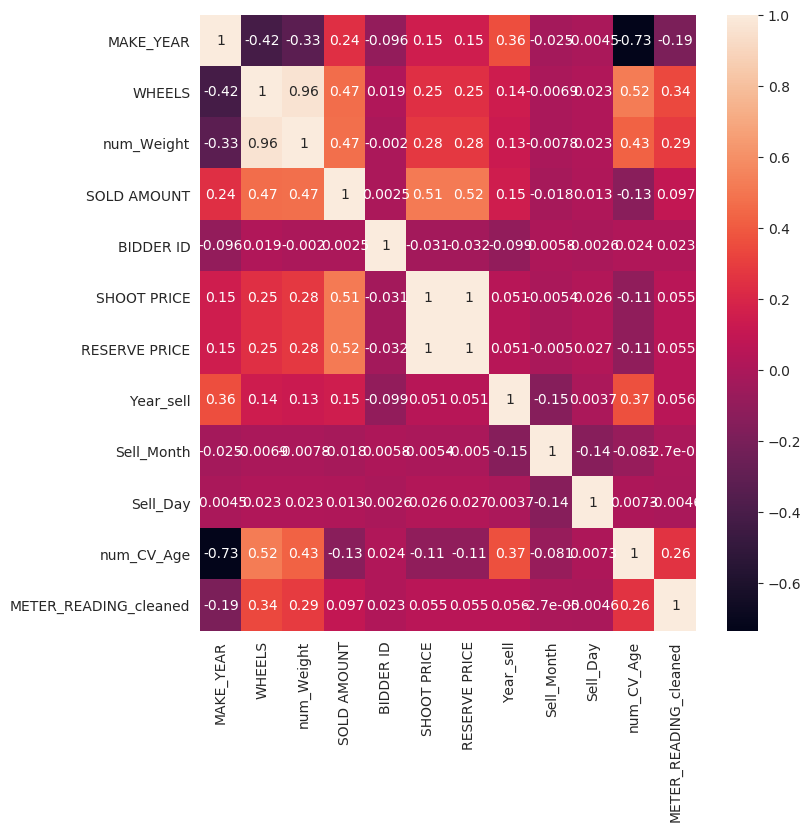

In [568]:
# Let's see the correlation matrix 
plt.figure(figsize = (8,8))        # Size of the figure
sns.heatmap(inp1.corr(),annot = True)
plt.show()

In [569]:
Unseen_df = df_2.loc[(df_2['SOLD_DATE'] >= '2022-03-01')]

In [570]:
Unseen_for_model=Unseen_df[['MMV','Fuel_Clean','BodyType', 'MAKE_YEAR',
       'SOLD AMOUNT', 'CV_State_Clean','SHROT COND_MAPPED','num_Weight',
       'num_CV_Age','PERMIT_MAPPED','INV_H_CATEGORY_mapping','METER_READING_cleaned',
           'INV_H_RC_STATUS_CLEANED_MAPPED','GP_PURPOSE_CLEANED','VEHICLECONDITION']]

In [571]:
mydata=df_2.loc[(df_2['SOLD_DATE'] < '2022-03-01')]

In [572]:
df_2=mydata[['MMV','Fuel_Clean','BodyType', 'MAKE_YEAR',
       'SOLD AMOUNT', 'CV_State_Clean','SHROT COND_MAPPED','num_Weight',
       'num_CV_Age','PERMIT_MAPPED','INV_H_CATEGORY_mapping','METER_READING_cleaned',
           'INV_H_RC_STATUS_CLEANED_MAPPED','GP_PURPOSE_CLEANED','VEHICLECONDITION']]

In [573]:
df_2.shape

(248733, 15)

In [574]:
columns=['MMV','Fuel_Clean','BodyType', 'MAKE_YEAR',
       'SOLD AMOUNT', 'CV_State_Clean','SHROT COND_MAPPED','num_Weight',
       'num_CV_Age','PERMIT_MAPPED','INV_H_CATEGORY_mapping','METER_READING_cleaned',
           'INV_H_RC_STATUS_CLEANED_MAPPED','GP_PURPOSE_CLEANED','VEHICLECONDITION']

In [575]:
#Feature Enginerring
df_2.reset_index(drop=True,inplace =True)

In [576]:
df_2.columns

Index(['MMV', 'Fuel_Clean', 'BodyType', 'MAKE_YEAR', 'SOLD AMOUNT',
       'CV_State_Clean', 'SHROT COND_MAPPED', 'num_Weight', 'num_CV_Age',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping', 'METER_READING_cleaned',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION'],
      dtype='object')

In [577]:
Unseen_for_model.reset_index(drop=True,inplace =True)

In [578]:
Model_data = df_2.copy()

In [579]:
Model_data.shape

(248733, 15)

In [580]:
cat_f=Model_data.select_dtypes(include='object').columns

In [581]:
cat_f=['MMV', 'Fuel_Clean', 'BodyType',
       'CV_State_Clean','SHROT COND_MAPPED', 
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION']

In [582]:
num_f=Model_data.select_dtypes(exclude='object').columns

In [583]:
num_f

Index(['MAKE_YEAR', 'SOLD AMOUNT', 'num_Weight', 'num_CV_Age',
       'METER_READING_cleaned'],
      dtype='object')

In [584]:
inp1=Model_data.select_dtypes(exclude='object')

No handles with labels found to put in legend.


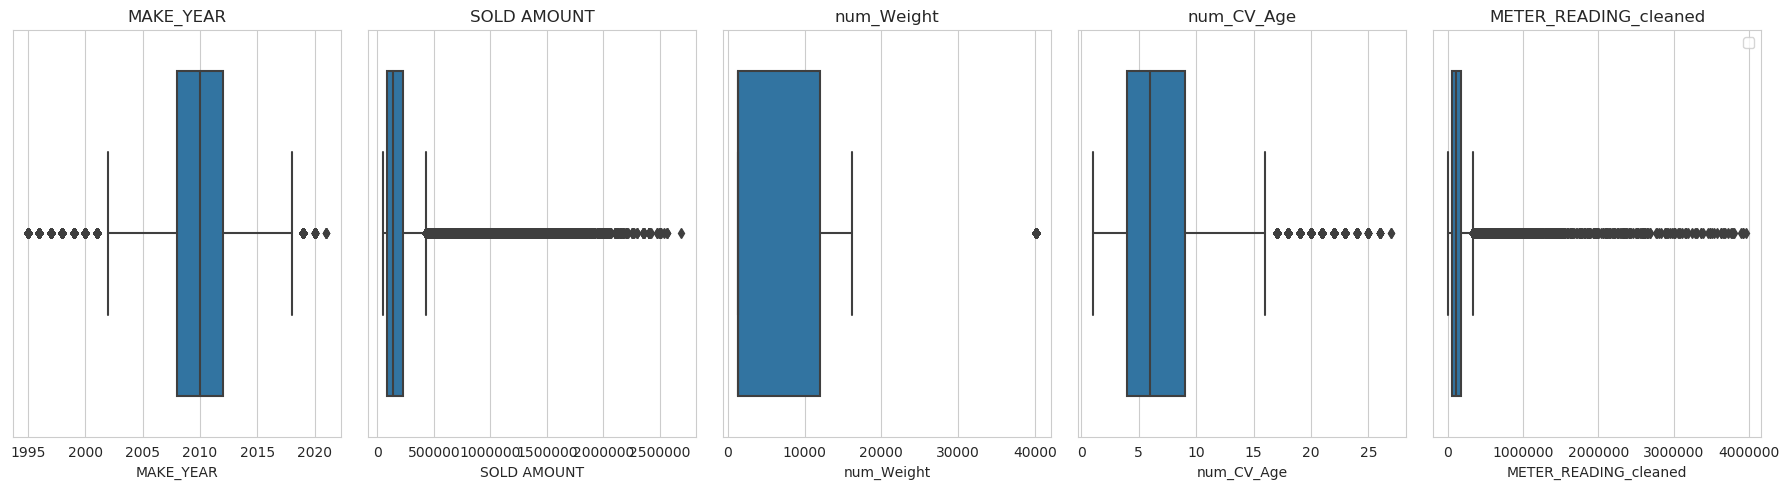

In [585]:
from scipy.stats import gaussian_kde
fig = plt.figure(figsize=(18,5))


for i,b in enumerate(list(inp1.columns)):
    
    i +=1
    ax = fig.add_subplot(1,5,i)
    sns.boxplot(inp1[b])

    ax.set_title(b)

sns.set_style("whitegrid")
plt.tight_layout()
plt.legend()
plt.show()

In [586]:
columns=Model_data.select_dtypes(exclude='object').columns

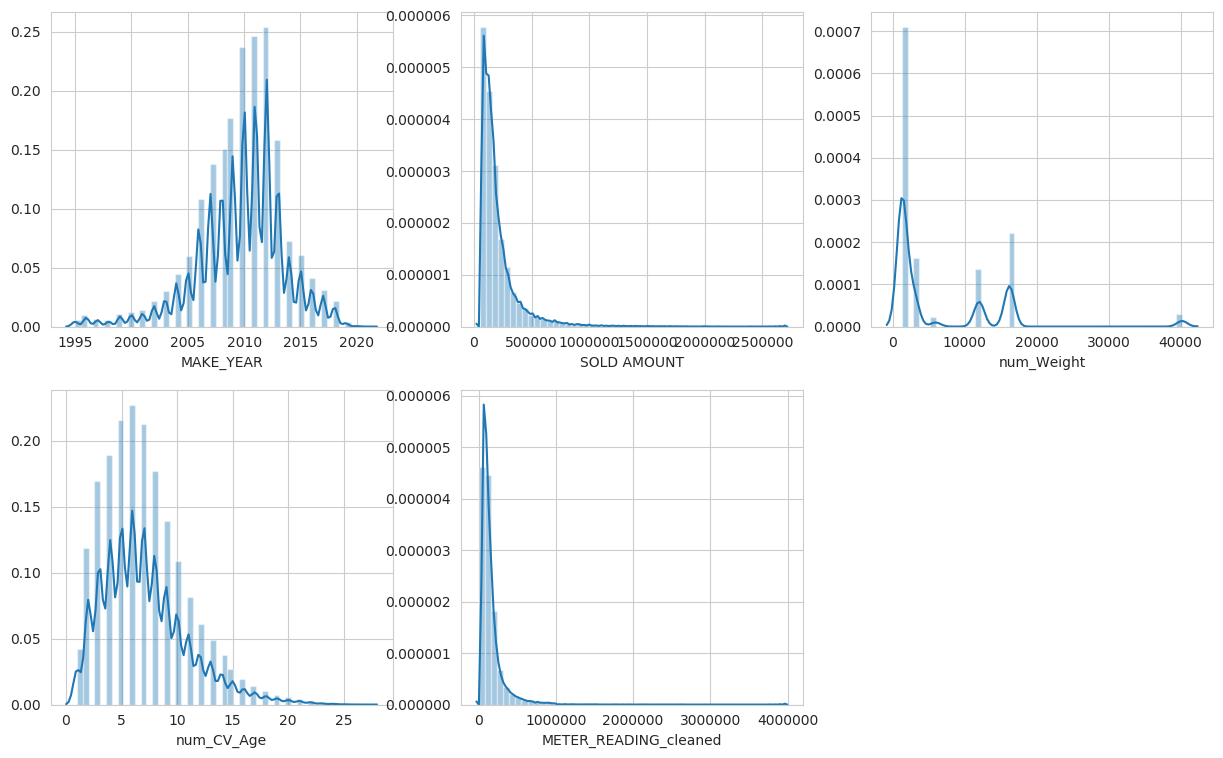

In [587]:
plt.subplots(figsize=(15,9))
 
for i, col in enumerate(inp1):
  plt.subplot(2,3,i+1)
  sns.distplot(inp1[col])
plt.show()

In [588]:
columns

Index(['MAKE_YEAR', 'SOLD AMOUNT', 'num_Weight', 'num_CV_Age',
       'METER_READING_cleaned'],
      dtype='object')

In [589]:
inp_cat=Model_data.select_dtypes(include='object')

In [590]:
inp_cat.columns

Index(['MMV', 'Fuel_Clean', 'BodyType', 'CV_State_Clean', 'SHROT COND_MAPPED',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION'],
      dtype='object')

In [591]:
Model_data.loc[Model_data['MMV'].isin((Model_data['MMV'].value_counts()[Model_data['MMV'].value_counts(normalize=True) < 0.005]).index), 'MMV'] = 'other'

In [592]:
Model_data["PERMIT_MAPPED"].value_counts()

NOT AVAILABLE     185399
NOT APPLICABLE     51655
VALID PERMIT        1760
Name: PERMIT_MAPPED, dtype: int64

In [593]:
Model_data['SHROT COND_MAPPED'].value_counts(normalize=True)

FAIR                 0.491
INVALID DETAILS      0.286
POOR                 0.121
AVERAGE              0.071
GOOD                 0.015
NOT VARIFIED         0.011
0                    0.002
IMMOVABLE            0.002
TO TAKE LEGAL CALL   0.001
SCRAP                0.000
ACCIDENTAL           0.000
Name: SHROT COND_MAPPED, dtype: float64

In [594]:
Model_data.loc[Model_data['SHROT COND_MAPPED'].isin((Model_data['SHROT COND_MAPPED'].value_counts()[Model_data['SHROT COND_MAPPED'].value_counts(normalize=True) < 0.015]).index), 'SHROT COND_MAPPED'] = 'other'

In [595]:
Model_data['SHROT COND_MAPPED'].value_counts(normalize=True)

FAIR              0.491
INVALID DETAILS   0.286
POOR              0.121
AVERAGE           0.071
other             0.016
GOOD              0.015
Name: SHROT COND_MAPPED, dtype: float64

In [596]:
Model_data['PERMIT_MAPPED'].value_counts()

NOT AVAILABLE     185399
NOT APPLICABLE     51655
VALID PERMIT        1760
Name: PERMIT_MAPPED, dtype: int64

In [597]:
Model_data['BodyType'].value_counts(normalize=True)

SCV                               0.486
HAULAGE TRUCK                     0.153
INTERMEDIATE COMMERCIAL VEHICLE   0.095
PICKUP                            0.088
MINI BUS                          0.076
BUS                               0.035
CAB AND CREW PICK UP              0.023
TRACTOR TRAILER                   0.021
LCV                               0.015
SUV                               0.004
TIPPER                            0.002
3W GCV                            0.001
INCOMPLETE                        0.000
HATCHBACK                         0.000
Name: BodyType, dtype: float64

In [598]:
Model_data.loc[Model_data['BodyType'].isin((Model_data['BodyType'].value_counts()[Model_data['BodyType'].value_counts(normalize=True) <= 0.020]).index), 'BodyType'] = 'other'

In [599]:
Model_data['BodyType'].value_counts(normalize=True)

SCV                               0.486
HAULAGE TRUCK                     0.153
INTERMEDIATE COMMERCIAL VEHICLE   0.095
PICKUP                            0.088
MINI BUS                          0.076
BUS                               0.035
CAB AND CREW PICK UP              0.023
other                             0.023
TRACTOR TRAILER                   0.021
Name: BodyType, dtype: float64

In [600]:
Model_data['INV_H_RC_STATUS_CLEANED_MAPPED'].value_counts(normalize=True)

ORIGINAL RC        0.553
NOT AVAILABLE      0.304
FRC                0.069
Original RC        0.024
Not available      0.021
DRC                0.016
RTA Forms          0.010
Fresh RC           0.002
ORIGINAL INVOICE   0.000
NOT APPLICABLE     0.000
Duplicate RC       0.000
Sale Letter        0.000
Name: INV_H_RC_STATUS_CLEANED_MAPPED, dtype: float64

In [601]:
Model_data.loc[Model_data['INV_H_RC_STATUS_CLEANED_MAPPED'].isin((Model_data['INV_H_RC_STATUS_CLEANED_MAPPED'].value_counts()[Model_data['INV_H_RC_STATUS_CLEANED_MAPPED'].value_counts(normalize=True) <= 0.013]).index), 'INV_H_RC_STATUS_CLEANED_MAPPED'] = 'other'

In [602]:
Model_data['INV_H_RC_STATUS_CLEANED_MAPPED'].value_counts(normalize=True)

ORIGINAL RC     0.553
NOT AVAILABLE   0.304
FRC             0.069
Original RC     0.024
Not available   0.021
DRC             0.016
other           0.013
Name: INV_H_RC_STATUS_CLEANED_MAPPED, dtype: float64

In [603]:
Model_data['CV_State_Clean'].value_counts(normalize=True)

TAMILNADU             0.266
ANDHRAPRADESH         0.244
KARNATAKA             0.129
MAHARASHTRA           0.080
UTTARPRADESH          0.051
RAJASTHAN             0.029
KERALA                0.027
MADHYAPRADESH         0.026
GUJARAT               0.025
HARYANA               0.018
WESTBENGAL            0.017
PUNJAB                0.016
CHHATTISGARH          0.015
TELANGANA             0.014
HIMACHALPRADESH       0.009
JHARKHAND             0.007
BIHAR                 0.006
PUDUCHERRY            0.005
ASSAM                 0.004
DELHI                 0.004
JAMMUANDKASHMIR       0.003
UTTARAKHAND           0.002
NAGALAND              0.001
ODISHA                0.001
GOA                   0.000
CHANDIGARH            0.000
DADARANDNAGARHAVELI   0.000
TRIPURA               0.000
DAMANANDDIU           0.000
MEGHALAYA             0.000
SIKKIM                0.000
ARUNACHALPRADESH      0.000
MIZORAM               0.000
MANIPUR               0.000
Name: CV_State_Clean, dtype: float64

In [604]:
Model_data['CV_State_Clean'].value_counts(normalize=True)

TAMILNADU             0.266
ANDHRAPRADESH         0.244
KARNATAKA             0.129
MAHARASHTRA           0.080
UTTARPRADESH          0.051
RAJASTHAN             0.029
KERALA                0.027
MADHYAPRADESH         0.026
GUJARAT               0.025
HARYANA               0.018
WESTBENGAL            0.017
PUNJAB                0.016
CHHATTISGARH          0.015
TELANGANA             0.014
HIMACHALPRADESH       0.009
JHARKHAND             0.007
BIHAR                 0.006
PUDUCHERRY            0.005
ASSAM                 0.004
DELHI                 0.004
JAMMUANDKASHMIR       0.003
UTTARAKHAND           0.002
NAGALAND              0.001
ODISHA                0.001
GOA                   0.000
CHANDIGARH            0.000
DADARANDNAGARHAVELI   0.000
TRIPURA               0.000
DAMANANDDIU           0.000
MEGHALAYA             0.000
SIKKIM                0.000
ARUNACHALPRADESH      0.000
MIZORAM               0.000
MANIPUR               0.000
Name: CV_State_Clean, dtype: float64

In [605]:
Model_data.loc[Model_data['CV_State_Clean'].isin((Model_data['CV_State_Clean'].value_counts()[Model_data['CV_State_Clean'].value_counts(normalize=True) <= 0.009]).index), 'CV_State_Clean'] = 'other'

In [606]:
Model_data.rename(columns={'CV_Age':'num_CV_Age'},inplace=True)
Model_data.rename(columns={'METER_READING_cleaned':'num_METER_READING_cleaned'},inplace=True)
Model_data.rename(columns={'SOLD AMOUNT':'num_SOLD_AMOUNT'},inplace=True)

In [607]:
Model_data.columns

Index(['MMV', 'Fuel_Clean', 'BodyType', 'MAKE_YEAR', 'num_SOLD_AMOUNT',
       'CV_State_Clean', 'SHROT COND_MAPPED', 'num_Weight', 'num_CV_Age',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping', 'num_METER_READING_cleaned',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION'],
      dtype='object')

In [608]:
num_f=['WHEELS', 'num_Weight', 'num_SOLD AMOUNT', 'num_CV_Age','num_METER_READING_cleaned']

In [609]:
num_features =  [col for col in Model_data if col.startswith('num_')]

In [610]:
#from scipy.stats import gaussian_kde
#fig = plt.figure(figsize=(18,5))
#
#
#for i,b in enumerate(list(Model_data[num_features].columns)):
#    
#    i +=1
#    ax = fig.add_subplot(1,5,i)
#    sns.boxplot(Model_data[num_features][b])
#
#    ax.set_title(b)
#
#sns.set_style("whitegrid")
#plt.tight_layout()
#plt.legend()
#plt.show()

In [611]:
#def remove_outlier_IQR(df):
#    Q1=df.quantile(0.05)
#    Q3=df.quantile(0.95)
#    IQR=Q3-Q1
#    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
#    return df_final

In [612]:
#Model_data[num_features] = remove_outlier_IQR(Model_data[num_features])

In [613]:
#finding the 0th moment 
print('0th moment is =',stats.moment(Model_data[num_features],moment=0))
#finding the 1st moment 
print('1st moment is =',stats.moment(Model_data[num_features],moment=1))
#finding the 2nd moment 
print('2nd moment is =',stats.moment(Model_data[num_features],moment=2))
#finding the 3rd moment 
print('3rd moment is =',stats.moment(Model_data[num_features],moment=3))
#finding the 4th moment 
print('4th moment is =',stats.moment(Model_data[num_features],moment=4))

0th moment is = [1. 1. 1. 1.]
1st moment is = [0. 0. 0. 0.]
2nd moment is = [3.44367728e+10            nan 1.47183794e+01            nan]
3rd moment is = [2.46098409e+16            nan 5.51904620e+01            nan]
4th moment is = [3.08748987e+22            nan 9.09160733e+02            nan]


In [614]:
#from scipy.stats import gaussian_kde
#fig = plt.figure(figsize=(18,5))
#
#
#for i,b in enumerate(list(Model_data[num_features].columns)):
#    
#    i +=1
#    ax = fig.add_subplot(1,5,i)
#    sns.boxplot(Model_data[num_features][b])
#
#    ax.set_title(b)
#
#sns.set_style("whitegrid")
#plt.tight_layout()
#plt.legend()
#plt.show()


In [615]:
Model_data.isnull().sum()/len(Model_data)

MMV                              0.000
Fuel_Clean                       0.000
BodyType                         0.000
MAKE_YEAR                        0.000
num_SOLD_AMOUNT                  0.000
CV_State_Clean                   0.000
SHROT COND_MAPPED                0.000
num_Weight                       0.115
num_CV_Age                       0.000
PERMIT_MAPPED                    0.040
INV_H_CATEGORY_mapping           0.000
num_METER_READING_cleaned        0.675
INV_H_RC_STATUS_CLEANED_MAPPED   0.000
GP_PURPOSE_CLEANED               0.123
VEHICLECONDITION                 0.127
dtype: float64

In [616]:
#!pip install verstack

In [617]:
#from verstack import NaNImputer


In [618]:
#imputer = NaNImputer(fill_nans_in_pure_text = True)
#Model_data = imputer.impute(Model_data)#

In [619]:
Model_data['MMV']

0                 TATAMAGIC4X2MINIBUS
1                    TATAACE4X2PICKUP
2                    TATAACE4X2PICKUP
3               MAHINDRAMAXX4X2PICKUP
4                  TATAACEHT4X2PICKUP
                     ...             
248728                          other
248729        MAHINDRABOLERO4X2PICKUP
248730           TATAACEMEGA4X2PICKUP
248731    ASHOKLEYLANDDOSTLS4X2PICKUP
248732                          other
Name: MMV, Length: 248733, dtype: object

In [620]:
#$ pip install verstack

In [621]:
#Model_data.fillna(Model_data.select_dtypes(include='number').median().iloc[0], inplace=True)

In [622]:
Model_data

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,NaN,7,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE
2,TATAACE4X2PICKUP,DIESEL,SCV,2009,76000,ANDHRAPRADESH,FAIR,1300.000,6,NOT AVAILABLE,CV,NaN,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE
3,MAHINDRAMAXX4X2PICKUP,DIESEL,PICKUP,2008,115000,ANDHRAPRADESH,INVALID DETAILS,2930.000,7,NOT AVAILABLE,CV,NaN,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE
4,TATAACEHT4X2PICKUP,DIESEL,SCV,2010,88000,ANDHRAPRADESH,FAIR,1300.000,5,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248728,other,DIESEL,PICKUP,2017,535000,ANDHRAPRADESH,FAIR,2930.000,4,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE
248729,MAHINDRABOLERO4X2PICKUP,DIESEL,PICKUP,2016,510000,ANDHRAPRADESH,AVERAGE,2930.000,5,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE
248730,TATAACEMEGA4X2PICKUP,DIESEL,SCV,2017,285000,ANDHRAPRADESH,AVERAGE,1300.000,4,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE
248731,ASHOKLEYLANDDOSTLS4X2PICKUP,DIESEL,SCV,2013,250000,ANDHRAPRADESH,FAIR,1300.000,8,NOT APPLICABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE


In [623]:
#Model_data.fillna(Model_data.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [624]:
S=Model_data[Model_data['VEHICLECONDITION']==2010.0]

In [625]:
S

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION


In [626]:
#Model_data.to_csv('Model_dataxx.csv')

In [627]:
Model_data_moment1=Model_data.groupby('MMV', as_index=False)['num_SOLD_AMOUNT']

In [628]:
Model_data_moment1=Model_data.groupby('MMV', as_index=False)['num_SOLD_AMOUNT'].mean().rename(columns = {'num_SOLD_AMOUNT':'Moment_1'})
#Model_data_moment1

In [629]:

Model_data_m1=Model_data.merge(Model_data_moment1,on='MMV',how='left')
#Model_data_m1.head()

In [630]:
Model_data_moment2=Model_data_m1.groupby('MMV', as_index=False)['num_SOLD_AMOUNT'].var().rename(columns = {'num_SOLD_AMOUNT':'Moment_2'})
#Model_data_moment2

In [631]:
Model_data_m2=Model_data_m1.merge(Model_data_moment2,on='MMV',how='left')

In [632]:
Model_data_moment3=Model_data_m2.groupby('MMV', as_index=False)['num_SOLD_AMOUNT'].skew(axis = 0, skipna = True).rename(columns = {'num_SOLD_AMOUNT':'Moment_3'})


In [633]:
#Model_data_m2.head()

In [634]:
Model_data_m3=Model_data_m2.merge(Model_data_moment3,on='MMV',how='left')

In [635]:
#Model_data_m3

In [636]:
Model_data_moment4=Model_data_m3.groupby('MMV', as_index=False)['num_SOLD_AMOUNT'].apply(pd.DataFrame.kurt).rename(columns = {'num_SOLD_AMOUNT':'Moment_4'})

In [637]:
#Model_data_moment4

In [638]:
Model_moment=Model_data_m3.merge(Model_data_moment4,on='MMV',how='left')

In [639]:
Model_data=Model_moment.copy()
Model_data

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,NaN,7,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083
2,TATAACE4X2PICKUP,DIESEL,SCV,2009,76000,ANDHRAPRADESH,FAIR,1300.000,6,NOT AVAILABLE,CV,NaN,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,118394.526,2616654886.305,1.105,2.083
3,MAHINDRAMAXX4X2PICKUP,DIESEL,PICKUP,2008,115000,ANDHRAPRADESH,INVALID DETAILS,2930.000,7,NOT AVAILABLE,CV,NaN,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,134894.712,4026839104.200,1.215,2.632
4,TATAACEHT4X2PICKUP,DIESEL,SCV,2010,88000,ANDHRAPRADESH,FAIR,1300.000,5,NOT AVAILABLE,CV,NaN,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,130406.377,3053817626.486,0.896,1.075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248728,other,DIESEL,PICKUP,2017,535000,ANDHRAPRADESH,FAIR,2930.000,4,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE,262110.149,75457567637.165,3.113,12.685
248729,MAHINDRABOLERO4X2PICKUP,DIESEL,PICKUP,2016,510000,ANDHRAPRADESH,AVERAGE,2930.000,5,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE,260297.985,17749291144.247,0.814,0.491
248730,TATAACEMEGA4X2PICKUP,DIESEL,SCV,2017,285000,ANDHRAPRADESH,AVERAGE,1300.000,4,NOT AVAILABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE,210815.198,4476463090.061,-0.055,-0.371
248731,ASHOKLEYLANDDOSTLS4X2PICKUP,DIESEL,SCV,2013,250000,ANDHRAPRADESH,FAIR,1300.000,8,NOT APPLICABLE,CV,NaN,Original RC,DELIVERY FOR BUYER,MOVABLE,233222.152,9210805154.981,0.735,0.501


In [640]:
Model_data['num_Weight']=Model_data['num_Weight'].fillna(Model_data['num_Weight'].mean())# "Mean"


In [641]:
Model_data['num_METER_READING_cleaned']=Model_data['num_METER_READING_cleaned'].fillna(Model_data['num_METER_READING_cleaned'].mean())# "Mean"

In [642]:
Model_data['PERMIT_MAPPED']=Model_data['PERMIT_MAPPED'].fillna(Model_data['PERMIT_MAPPED'].mode()[0]) # "Mode"


In [643]:
Model_data['GP_PURPOSE_CLEANED']=Model_data['GP_PURPOSE_CLEANED'].fillna(Model_data['GP_PURPOSE_CLEANED'].mode()[0]) # "Mode"

In [644]:
Model_data['VEHICLECONDITION']=Model_data['VEHICLECONDITION'].fillna(Model_data['VEHICLECONDITION'].mode()[0]) # "Mode"

In [645]:
Model_data.columns

Index(['MMV', 'Fuel_Clean', 'BodyType', 'MAKE_YEAR', 'num_SOLD_AMOUNT',
       'CV_State_Clean', 'SHROT COND_MAPPED', 'num_Weight', 'num_CV_Age',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping', 'num_METER_READING_cleaned',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION', 'Moment_1', 'Moment_2', 'Moment_3', 'Moment_4'],
      dtype='object')

In [646]:
Model_data.isnull().sum()

MMV                               0
Fuel_Clean                        0
BodyType                          0
MAKE_YEAR                         0
num_SOLD_AMOUNT                   0
CV_State_Clean                    0
SHROT COND_MAPPED                 0
num_Weight                        0
num_CV_Age                        0
PERMIT_MAPPED                     0
INV_H_CATEGORY_mapping            0
num_METER_READING_cleaned         0
INV_H_RC_STATUS_CLEANED_MAPPED    0
GP_PURPOSE_CLEANED                0
VEHICLECONDITION                  0
Moment_1                          0
Moment_2                          0
Moment_3                          0
Moment_4                          0
dtype: int64

In [647]:
Model_data_=Model_data[['MMV', 'Fuel_Clean', 'BodyType', 'MAKE_YEAR', 'num_SOLD_AMOUNT',
       'CV_State_Clean', 'SHROT COND_MAPPED', 'num_Weight', 'num_CV_Age',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping', 'num_METER_READING_cleaned',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION', 'Moment_1', 'Moment_2', 'Moment_3', 'Moment_4']]

In [648]:
X=Model_data_.drop(['num_SOLD_AMOUNT'],axis=1)
y=Model_data_[['num_SOLD_AMOUNT']]

In [649]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [650]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [651]:
Model_data.head(2)

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,6243.347,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083


In [652]:
Model_data['GP_PURPOSE_CLEANED'].value_counts()

DELIVERY FOR BUYER               246051
0                                  2663
DELIVERY DUE TO UNSOLD STATUS        19
Name: GP_PURPOSE_CLEANED, dtype: int64

In [653]:
Model_data['VEHICLECONDITION'].value_counts()

MOVABLE         154915
IMMOVABLE        91143
PHOTOAUCTION      2675
Name: VEHICLECONDITION, dtype: int64

In [654]:
Model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248733 entries, 0 to 248732
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   MMV                             248733 non-null  object 
 1   Fuel_Clean                      248733 non-null  object 
 2   BodyType                        248733 non-null  object 
 3   MAKE_YEAR                       248733 non-null  int64  
 4   num_SOLD_AMOUNT                 248733 non-null  int64  
 5   CV_State_Clean                  248733 non-null  object 
 6   SHROT COND_MAPPED               248733 non-null  object 
 7   num_Weight                      248733 non-null  float64
 8   num_CV_Age                      248733 non-null  int64  
 9   PERMIT_MAPPED                   248733 non-null  object 
 10  INV_H_CATEGORY_mapping          248733 non-null  object 
 11  num_METER_READING_cleaned       248733 non-null  float64
 12  INV_H_RC_STATUS_

In [655]:
ohe=OneHotEncoder()
ohe.fit(X[['MMV', 'Fuel_Clean', 'BodyType',
       'CV_State_Clean', 'SHROT COND_MAPPED',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [656]:
column_trans=make_column_transformer((OneHotEncoder(categories=ohe.categories_),['MMV', 'Fuel_Clean', 'BodyType',
       'CV_State_Clean', 'SHROT COND_MAPPED',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION']),remainder='passthrough')

In [657]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories=[array(['ASHOKLEYLAND1611COMET4X2CARGOTRUCK',
       'ASHOKLEYLAND2214/1S6X2CARGOTRUCK',
       'ASHOKLEYLAND22146X2CARGOTRUCK', 'ASHOKLEYLAND25166X2CARGOTRUCK',
       'ASHOKLEYLAND31168X2CARGOTRUCK', 'ASHOKLEYLANDDOST4...
                                                           array(['0', 'DELIVERY DUE TO UNSOLD STATUS', 'DELIVERY FOR BUYER'],
      dtype=object),
                                                           array(['IMMOVABLE', 'MOVABLE', 'PHOTOAUCTION'], dtype=object)],
                                               drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
       

In [658]:
#!pip install xgboost


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [659]:
from sklearn import model_selection
from xgboost import XGBRegressor

In [660]:
regressor=XGBRegressor(max_depth=10,learning_rate=0.01,
                   n_estimators=2000,
                   objective='reg:squarederror',
                   booster='gbtree')

In [661]:
#regressor = XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=0.1, gamma=0, learning_rate=0.001, max_delta_step=0.7,
#       max_depth=10, min_child_num_Weight=2, missing=1, n_estimators=850,
#       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=707,
#       reg_alpha=10, reg_lambda=300, scale_pos_num_Weight=0.1, seed=42,
#       silent=True, subsample=0.1)

In [662]:
pipe=make_pipeline(column_trans,regressor)

In [663]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['ASHOKLEYLAND1611COMET4X2CARGOTRUCK',
       'ASHOKLEYLAND2214/1S6X2CARGOTRUCK',
       'ASHOKLEYLAND22146X2CARGOTRUCK', 'ASHOKLEYLAND25166X2CARGOTRUCK',
       '...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.01, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=10, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()'

In [664]:
y_pred=pipe.predict(X_test)
y_pred

array([136439.69, 194199.16, 147862.36, ..., 144476.55, 260886.72,
       101113.49], dtype=float32)

In [665]:
y_train_pred=pipe.predict(X_train)
y_train_pred

array([260781.23, 223179.56, 152728.38, ...,  79743.44, 213459.16,
       204535.39], dtype=float32)

In [666]:
r2_score(y_train,y_train_pred)

0.8827288989542158

In [667]:
r2_score(y_test,y_pred)

0.8114273513398685

In [668]:
import pickle

In [669]:
pickle.dump(pipe,open('FInal_regressor_CV_CS_NEW_00.pkl','wb'))

In [670]:
Model_data.head(5)

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,6243.347,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083
2,TATAACE4X2PICKUP,DIESEL,SCV,2009,76000,ANDHRAPRADESH,FAIR,1300.000,6,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,118394.526,2616654886.305,1.105,2.083
3,MAHINDRAMAXX4X2PICKUP,DIESEL,PICKUP,2008,115000,ANDHRAPRADESH,INVALID DETAILS,2930.000,7,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,134894.712,4026839104.200,1.215,2.632
4,TATAACEHT4X2PICKUP,DIESEL,SCV,2010,88000,ANDHRAPRADESH,FAIR,1300.000,5,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,130406.377,3053817626.486,0.896,1.075


In [671]:
pipe.predict(pd.DataFrame(columns=['MMV', 'Fuel_Clean', 'BodyType', 'MAKE_YEAR',
       'CV_State_Clean', 'SHROT COND_MAPPED', 'num_Weight', 'num_CV_Age',
       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping', 'num_METER_READING_cleaned',
       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
       'VEHICLECONDITION', 'Moment_1', 'Moment_2', 'Moment_3', 'Moment_4'],data=np.array(['TATAMAGIC4X2MINIBUS','DIESEL','MINI BUS',2008,'ANDHRAPRADESH','FAIR',6243.347,7,'NOT AVAILABLE','CV',144776.150,'ORIGINAL RC','DELIVERY FOR BUYER','MOVABLE',110539.986,2259516545.104,1.187,2.986]).reshape(1,18)))

array([79405.74], dtype=float32)

In [672]:
X_train_copy=X_train.copy()

In [673]:
X_train_copy['Predicted']=y_train_pred

In [674]:
X_train_copy['Actual']=y_train

In [675]:
X_train_copy['Predicted']

222119   260781.234
163445   223179.562
19897    152728.375
154656   206325.703
65932    126654.430
            ...    
119879   640693.500
103694    88750.195
131932    79743.438
146867   213459.156
121958   204535.391
Name: Predicted, Length: 198986, dtype: float32

In [676]:
X_train_copy.head(20)

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4,Predicted,Actual
222119,ASHOKLEYLANDDOST4X2PICKUP,DIESEL,SCV,2015,ANDHRAPRADESH,POOR,1300.000,4,NOT AVAILABLE,CV,191824.000,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,215710.629,9290270772.099,0.983,1.374,260781.234,270000
163445,EICHER10.954X2CARGOTRUCK,DIESEL,INTERMEDIATE COMMERCIAL VEHICLE,2008,KARNATAKA,INVALID DETAILS,11990.000,9,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,257590.002,26380930763.369,1.090,0.973,223179.562,260000
19897,TATAACEEX4X2PICKUP,DIESEL,SCV,2012,ANDHRAPRADESH,INVALID DETAILS,1300.000,3,NOT APPLICABLE,CV,144776.150,DRC,DELIVERY FOR BUYER,IMMOVABLE,112627.727,1882079391.095,0.939,1.475,152728.375,85000
154656,TATA207DI4X2PICKUP,DIESEL,CAB AND CREW PICK UP,2012,UTTARPRADESH,POOR,2960.000,2,NOT APPLICABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,125440.401,4760610766.852,1.109,0.962,206325.703,173000
65932,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2010,ANDHRAPRADESH,FAIR,6243.347,3,NOT AVAILABLE,CV,12764.000,FRC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986,126654.430,150000
202947,TATASUPERACE4X2PICKUP,DIESEL,SCV,2013,TAMILNADU,FAIR,1300.000,6,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,145445.578,3567293745.465,0.495,-0.229,126337.125,180000
143365,ASHOKLEYLAND22146X2CARGOTRUCK,DIESEL,HAULAGE TRUCK,2003,ANDHRAPRADESH,GOOD,16200.000,9,NOT AVAILABLE,CV,144776.150,FRC,DELIVERY FOR BUYER,MOVABLE,329776.120,26032929286.824,1.237,1.532,327619.750,225000
164743,ASHOKLEYLANDDOSTLS4X2PICKUP,DIESEL,SCV,2012,TAMILNADU,FAIR,1300.000,4,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,233222.152,9210805154.981,0.735,0.501,209826.328,190000
220796,other,DIESEL,BUS,2016,other,AVERAGE,6243.347,3,NOT AVAILABLE,CV,63760.000,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,262110.149,75457567637.165,3.113,12.685,476960.781,550000
101289,ASHOKLEYLAND1611COMET4X2CARGOTRUCK,DIESEL,INTERMEDIATE COMMERCIAL VEHICLE,1998,KARNATAKA,INVALID DETAILS,11990.000,17,NOT AVAILABLE,CV,144776.150,FRC,DELIVERY FOR BUYER,IMMOVABLE,146927.885,6660743365.287,4.290,32.366,126048.203,130000


In [677]:
MAPE=abs((X_train_copy['Actual']-X_train_copy['Predicted'])/X_train_copy['Actual']).mean()*100

In [678]:
MAPE

25.41057845184127

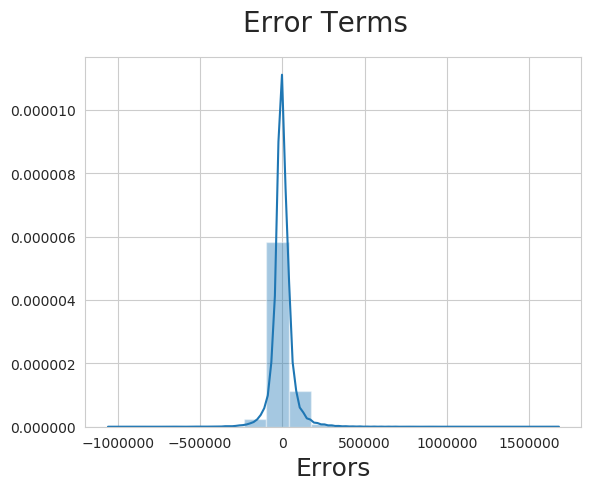

In [679]:
# Plot the histogram of the error terms
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.distplot((X_train_copy['Actual'] - X_train_copy['Predicted']), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)  
plt.show()

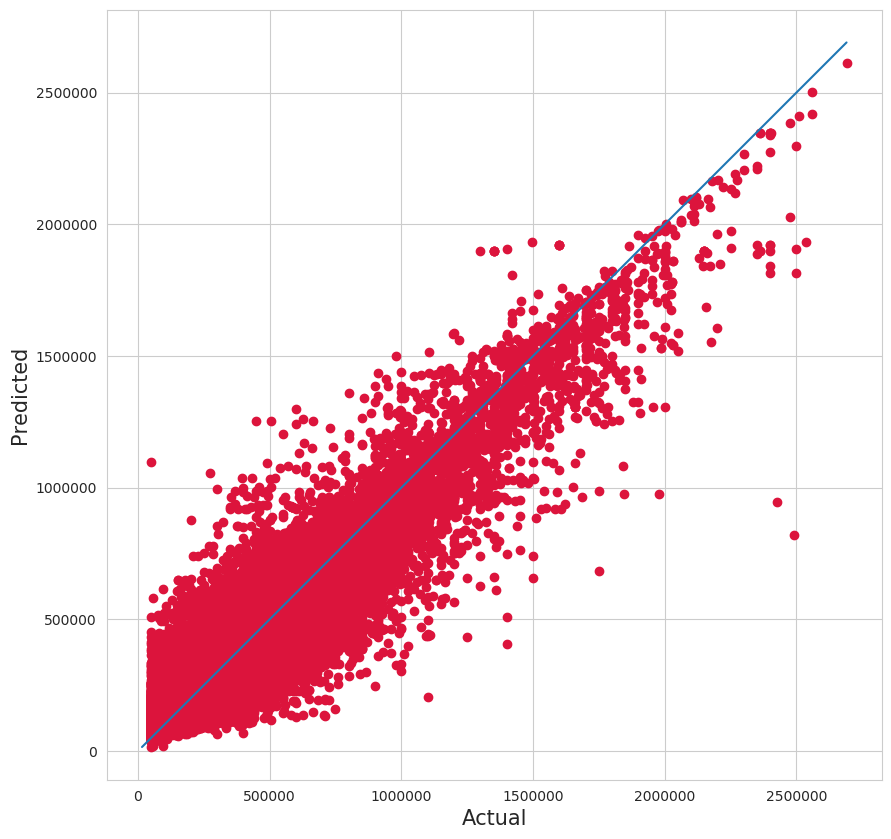

In [680]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_copy['Actual'], X_train_copy['Predicted'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(X_train_copy['Predicted']), max(X_train_copy['Actual']))
p2 = min(min(X_train_copy['Predicted']), min(X_train_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

In [681]:
X_test_copy=X_test.copy()
X_test_copy['Predicted']=y_pred
X_test_copy['Actual']=y_test


In [682]:
X_test_copy['Predicted']

67481    136439.688
89039    194199.156
12528    147862.359
68530     94856.625
236860    78985.172
            ...    
103006    77659.016
52415    288561.344
28387    144476.547
89189    260886.719
164717   101113.492
Name: Predicted, Length: 49747, dtype: float32

In [683]:
X_test_copy.head(20)

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4,Predicted,Actual
67481,TATAACEZIP4X2PICKUP,DIESEL,SCV,2014,MAHARASHTRA,INVALID DETAILS,1300.000,2,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,85448.943,970614449.150,1.532,5.048,136439.688,160000
89039,ASHOKLEYLANDDOST4X2PICKUP,DIESEL,SCV,2012,KARNATAKA,FAIR,1300.000,6,NOT AVAILABLE,CV,151753.000,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,215710.629,9290270772.099,0.983,1.374,194199.156,125000
12528,MAHINDRAMAXXIMO4X2PICKUP,DIESEL,SCV,2011,KERALA,FAIR,1300.000,2,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,99881.365,1593247544.607,1.129,1.780,147862.359,178000
68530,TATAACE4X2PICKUP,DIESEL,SCV,2007,MAHARASHTRA,FAIR,1300.000,7,NOT AVAILABLE,CV,89032.000,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,118394.526,2616654886.305,1.105,2.083,94856.625,75000
236860,TATAACEMEGA4X2PICKUP,DIESEL,SCV,2016,WESTBENGAL,other,1300.000,5,NOT APPLICABLE,CV,144776.150,Not available,0,MOVABLE,210815.198,4476463090.061,-0.055,-0.371,78985.172,110000
95313,TATAACE4X2PICKUP,DIESEL,SCV,2010,TAMILNADU,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083,100751.805,80000
224679,other,DIESEL,BUS,2008,ANDHRAPRADESH,POOR,6243.347,11,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,262110.149,75457567637.165,3.113,12.685,136338.688,130000
6738,MAHINDRAMAXXIMO4X2PICKUP,DIESEL,SCV,2012,MADHYAPRADESH,INVALID DETAILS,1300.000,3,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,99881.365,1593247544.607,1.129,1.780,90474.359,90000
213094,other,DIESEL,BUS,2012,ANDHRAPRADESH,FAIR,6243.347,8,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,262110.149,75457567637.165,3.113,12.685,321751.188,280000
187364,TATALPT25186X2CARGOTRUCK,DIESEL,HAULAGE TRUCK,2012,UTTARPRADESH,POOR,16200.000,9,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,337494.983,30978575161.995,2.368,10.164,277292.156,290000


In [684]:
MAPE_test=abs((X_test_copy['Actual']-X_test_copy['Predicted'])/X_test_copy['Actual']).mean()*100

In [685]:
MAPE_test

28.146796690735737

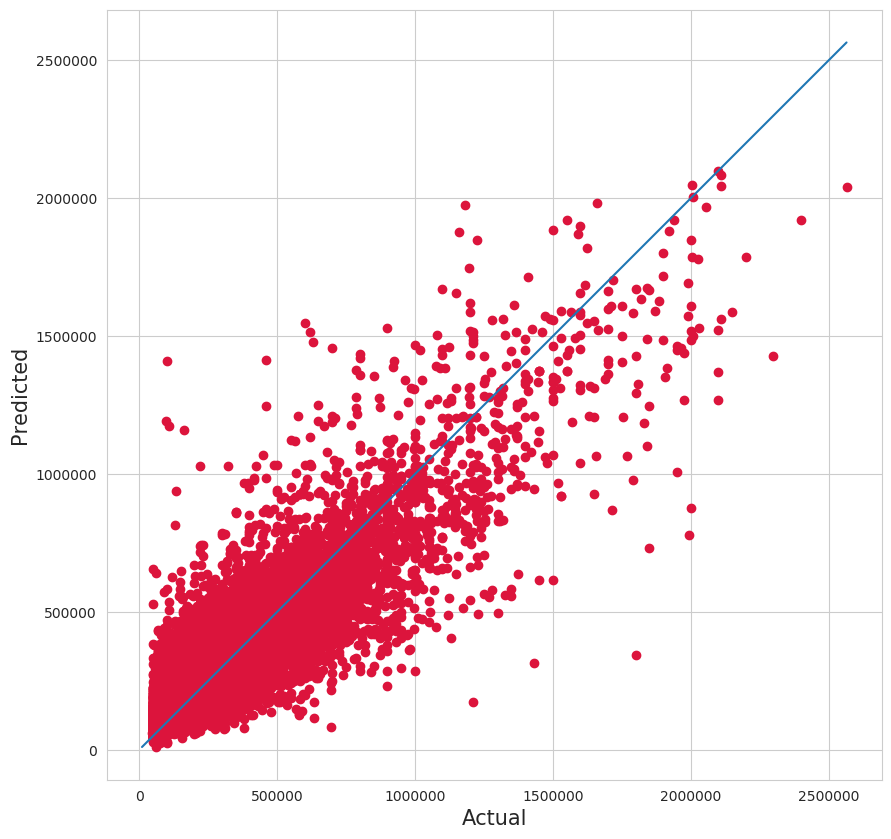

In [686]:
plt.figure(figsize=(10,10))
plt.scatter(X_test_copy['Actual'], X_test_copy['Predicted'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(X_test_copy['Predicted']), max(X_test_copy['Actual']))
p2 = min(min(X_test_copy['Predicted']), min(X_test_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

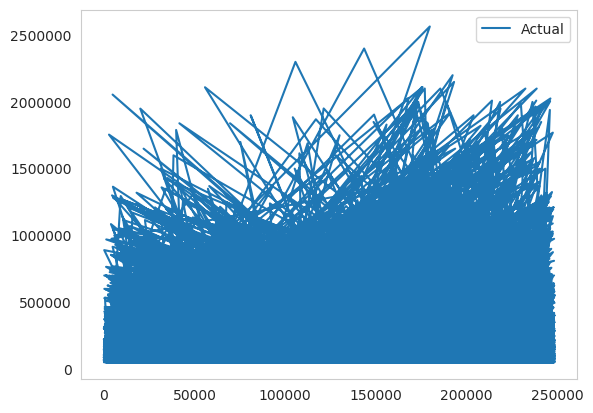

In [687]:
plt.plot(X_test_copy['Actual'],label='Actual')
#plt.plot(X_test_copy['Predicted'],label='Predicted')
plt.legend()
plt.grid()
plt.show()

In [688]:
plt.plot(X_train_copy['Actual'],label='Actual')
plt.plot(X_train_copy['Predicted'],label='Predicted')
plt.legend()
plt.grid()
plt.show()

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 640x480 with 1 Axes>

In [689]:
#Model_data_moment4=Model_data.groupby('MMV', as_index=False)['num_SOLD_AMOUNT']
#profile = pp.ProfileReport(Model_data)
#profile.to_file("output.html")

In [690]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [691]:
#for i in range(len(Model_data.columns[:-1])):
#    v=vif(np.matrix(Model_data[:-1]),i)
#    print('Varince {}:{}'.format(Model_data[i],round(v,2)))

In [692]:
#Model_data.merge(Model_data_moment1,on='MMV',how='left')
#Model_data.merge(Model_data_moment2,on='MMV',how='left')
#Model_data.merge(Model_data_moment3,on='MMV',how='left')
#Model_data.merge(Model_data_moment4,on='MMV',how='left')
#Model_data.head()

In [693]:
#one_hot_encoded_data = pd.get_dummies(Model_data, columns = ['MMV','Fuel_Clean', 'BodyType',
#       'CV_State_Clean','SHROT COND_MAPPED', 
#       'PERMIT_MAPPED', 'INV_H_CATEGORY_mapping',
#       'INV_H_RC_STATUS_CLEANED_MAPPED', 'GP_PURPOSE_CLEANED',
#       'VEHICLECONDITION'])

In [694]:
#one_hot_encoded_data.shape

In [695]:
#Model_data=one_hot_encoded_data.copy()

In [696]:
Model_data.head()

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,6243.347,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,1300.000,7,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083
2,TATAACE4X2PICKUP,DIESEL,SCV,2009,76000,ANDHRAPRADESH,FAIR,1300.000,6,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,118394.526,2616654886.305,1.105,2.083
3,MAHINDRAMAXX4X2PICKUP,DIESEL,PICKUP,2008,115000,ANDHRAPRADESH,INVALID DETAILS,2930.000,7,NOT AVAILABLE,CV,144776.150,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,134894.712,4026839104.200,1.215,2.632
4,TATAACEHT4X2PICKUP,DIESEL,SCV,2010,88000,ANDHRAPRADESH,FAIR,1300.000,5,NOT AVAILABLE,CV,144776.150,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,130406.377,3053817626.486,0.896,1.075


In [697]:
num_features=['num_Weight', 'num_CV_Age',
       'num_METER_READING_cleaned']

In [698]:
#Q1 = num_f.quantile(0.25)
#Q3 = num_f.quantile(0.75)
#IQR = Q3 - Q1
#print(IQR)

In [699]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()
Model_data[num_features]=scaler.fit_transform(Model_data[num_features])

In [700]:
Model_data.head()

,MMV,Fuel_Clean,BodyType,MAKE_YEAR,num_SOLD_AMOUNT,CV_State_Clean,SHROT COND_MAPPED,num_Weight,num_CV_Age,PERMIT_MAPPED,INV_H_CATEGORY_mapping,num_METER_READING_cleaned,INV_H_RC_STATUS_CLEANED_MAPPED,GP_PURPOSE_CLEANED,VEHICLECONDITION,Moment_1,Moment_2,Moment_3,Moment_4
0,TATAMAGIC4X2MINIBUS,DIESEL,MINI BUS,2008,87000,ANDHRAPRADESH,FAIR,0.127,0.231,NOT AVAILABLE,CV,0.036,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,110539.986,2259516545.104,1.187,2.986
1,TATAACE4X2PICKUP,DIESEL,SCV,2008,125000,ANDHRAPRADESH,INVALID DETAILS,0.000,0.231,NOT AVAILABLE,CV,0.036,ORIGINAL RC,DELIVERY FOR BUYER,IMMOVABLE,118394.526,2616654886.305,1.105,2.083
2,TATAACE4X2PICKUP,DIESEL,SCV,2009,76000,ANDHRAPRADESH,FAIR,0.000,0.192,NOT AVAILABLE,CV,0.036,NOT AVAILABLE,DELIVERY FOR BUYER,MOVABLE,118394.526,2616654886.305,1.105,2.083
3,MAHINDRAMAXX4X2PICKUP,DIESEL,PICKUP,2008,115000,ANDHRAPRADESH,INVALID DETAILS,0.042,0.231,NOT AVAILABLE,CV,0.036,NOT AVAILABLE,DELIVERY FOR BUYER,IMMOVABLE,134894.712,4026839104.200,1.215,2.632
4,TATAACEHT4X2PICKUP,DIESEL,SCV,2010,88000,ANDHRAPRADESH,FAIR,0.000,0.154,NOT AVAILABLE,CV,0.036,ORIGINAL RC,DELIVERY FOR BUYER,MOVABLE,130406.377,3053817626.486,0.896,1.075


In [701]:
Model_data1=Model_data.copy()

In [702]:
#from scipy import stats
#import numpy as np
#z = np.abs(stats.zscore(model_data1))
#print(z)

In [703]:
#threshold = 3
#print(np.where(z > 3))

In [704]:
#Q1 = model_data1.quantile(0.25)
#Q3 = model_data1.quantile(0.75)
#IQR = Q3 - Q1
#print(IQR)

In [705]:
#print(model_data1 < (Q1 - 1.5 * IQR)) |(model_data1 > (Q3 + 1.5 * IQR))

In [706]:
#model_data.info()
#Model_data=model_data.reset_index()

In [707]:
X=Model_data.drop(['num_SOLD_AMOUNT'],axis=1)
y=Model_data[['num_SOLD_AMOUNT']]

In [708]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.25,
                                                                    shuffle=True,
                                                                    random_state=0)
print(y.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

248733
186549
62184


In [709]:
!pip install xgboost



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [710]:
import xgboost
regressor=xgboost.XGBRegressor()

In [711]:
clf = xgboost.XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.1, gamma=0, learning_rate=0.001, max_delta_step=0.7,
       max_depth=10, min_child_num_Weight=2, missing=1, n_estimators=850,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=707,
       reg_alpha=10, reg_lambda=300, scale_pos_num_Weight=0.1, seed=42,
       silent=True, subsample=0.1)

In [712]:
clf.fit(X_train, y_train, early_stopping_rounds=900, eval_metric=["mape",'error','logloss'],
        eval_set=[(X_train, y_train), (X_test, y_test)],verbose=0)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:MMV, Fuel_Clean, BodyType, CV_State_Clean, SHROT COND_MAPPED, PERMIT_MAPPED, INV_H_CATEGORY_mapping, INV_H_RC_STATUS_CLEANED_MAPPED, GP_PURPOSE_CLEANED, VEHICLECONDITION

In [ ]:
#clf.fit(X_train, y_train)
results = clf.evals_result()

plt.figure(figsize=(8,5))
plt.plot(results["validation_0"]["mape"], label="Training loss")
plt.plot(results["validation_1"]["mape"], label="Test loss")
plt.axvline(21, color="gray", label="Base")
plt.xlabel("Number of rounds")
plt.ylabel("Loss")
plt.legend()



In [ ]:
clf.best_ntree_limit

In [ ]:
booster=['gbtree','gblinear']
base_score=[0.25,0.5,0.75,1]

In [ ]:
n_estimators = [100, 500, 900, 1100, 1500]
#n_estimators = [100, 500]
max_depth = [2, 3, 5, 8, 10, 12, 15]
learning_rate=[0.001,0.01,0.05,0.1,0.15,0.20,0.30]
min_child_num_Weight=[1,2,3,4,5,7]
#'min_child_weight': np.arange(0.1, 10.1, 0.1)
#gamma=[7,10]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_num_Weight':min_child_num_Weight,
    #'min_child_weight': np.arange(0.1, 10.1, 0.1),
    'booster':booster,
    'base_score':base_score,
    #'gamma':gamma
    }#

In [ ]:
# Set up the random search with 2-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=2,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42,
            refit=True)

In [ ]:
#i=1
#kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
#for train_index,test_index in kf.split(X,y):
#     print('\n{} of kfold {}'.format(i,kf.n_splits))
#     xtr,xvl = X.loc[train_index],X.loc[test_index]
#     ytr,yvl = y[train_index],y[test_index]
#     model = GridSearchCV(XGBClassifier() ,param_distributions=hyperparameter_grid, cv=10, scoring= 'f1',iid=True)
#     model.fit(xtr, ytr)
#     print (model.best_params_)
#     pred=model.predict(xvl)
#     print('accuracy_score',accuracy_score(yvl,pred))
#     i+=1

In [ ]:
random_cv.fit(X_train,y_train)


In [ ]:
 random_cv.best_params_, random_cv.best_score_, random_cv.best_estimator_

In [ ]:
y_train_pred=random_cv.predict(X_train)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_train,y_train_pred)

In [ ]:
X_train_copy=X_train.copy()

In [ ]:
X_train_copy['Predicted']=y_train_pred

In [ ]:
X_train_copy['Actual']=y_train

In [ ]:
X_train_copy['Predicted']

In [ ]:
X_train_copy.head()

In [ ]:
MAPE=abs((X_train_copy['Actual']-X_train_copy['Predicted'])/X_train_copy['Actual']).mean()*100

In [ ]:
MAPE

In [ ]:
# Plot the histogram of the error terms
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.distplot((X_train_copy['Actual'] - X_train_copy['Predicted']), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)  
plt.show()

In [ ]:
plt.ion()
plt.figure(figsize=(10,10))
plt.scatter(X_train_copy['Actual'], X_train_copy['Predicted'], c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(X_train_copy['Predicted']), max(X_train_copy['Actual']))
p2 = min(min(X_train_copy['Predicted']), min(X_train_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.ion()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.set_context("notebook")
ax1 = sns.distplot(X_train_copy['Actual'], hist=False, color="r", label="Actual Value")
sns.distplot(X_train_copy['Predicted'], hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
p1 = max(max(X_train_copy['Predicted']), max(X_train_copy['Actual']))
p2 = min(min(X_train_copy['Predicted']), min(X_train_copy['Actual']))
#px.plot([p1, p2], [p1, p2])
#px.xlabel('Actual', fontsize=15)
#px.ylabel('Predicted', fontsize=15)
#px.axis('equal')
#px.show()
#df = px.data.tips()
fig = px.scatter(X_train_copy, x = "Actual", y = "Predicted")
fig.add_traces(go.Scatter(x=[p1,p2], y=[p1,p2], name='Regression Fit'))
fig.show()

In [ ]:
y_test_pred=random_cv.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:

predictions = [round(value) for value in y_test_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
r2_score(y_test,y_test_pred)

In [ ]:
X_test_copy=X_test.copy()
X_test_copy['Predicted']=y_test_pred
X_test_copy['Actual']=y_test


In [ ]:
X_test_copy['Predicted']

In [ ]:
X_test_copy.head()

In [ ]:
X_test = Model_data.transform(X_test)

In [ ]:
MAPE_test=abs((X_test_copy['Actual']-X_test_copy['Predicted'])/X_test_copy['Actual']).mean()*100

In [ ]:
MAPE_test

In [ ]:
plt.figure(figsize=(10,8))
sns.set_context("notebook")
ax1 = sns.distplot(X_test_copy['Actual'], hist=False, color="r", label="Actual Value")
sns.distplot(X_test_copy['Predicted'], hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.show()

In [ ]:
# Plot the histogram of the error terms
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.distplot((X_test_copy['Actual'] - X_test_copy['Predicted']), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)  
plt.show()

In [ ]:
# Fit the model
#_model_ = smf.ols("outcome ~ predictor", data=Model_data).fit()



In [ ]:
# Print the summary statistics
#print(_model_.summary())

# Make predictions
#predictions = model.predict(Model_data)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_test_copy['Actual'], X_test_copy['Predicted'], c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(X_test_copy['Predicted']), max(X_test_copy['Actual']))
p2 = min(min(X_test_copy['Predicted']), min(X_test_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    early_stopping_rounds = range(1, len(train_metrics) + 1)
    plt.plot(early_stopping_rounds, train_metrics)
    plt.plot(early_stopping_rounds, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(history, 'loss')

In [ ]:

import statsmodels.formula.api as smf

# Load the data
#df = pd.read_csv("data.csv")

# Fit the model
model = smf.ols("outcome ~ predictor", data=Model_data).fit()

# Print the summary statistics
print(model.summary())

# Make predictions
predictions = model.predict(Model_data)






